Epoch 1/10
45/45 [==============================] - 18s 343ms/step - loss: 1.9234 - accuracy: 0.3931 - val_loss: 1.2567 - val_accuracy: 0.5625
Epoch 2/10
45/45 [==============================] - 15s 332ms/step - loss: 0.9241 - accuracy: 0.6521 - val_loss: 1.0882 - val_accuracy: 0.6500
Epoch 3/10
45/45 [==============================] - 15s 329ms/step - loss: 0.5743 - accuracy: 0.8021 - val_loss: 0.6644 - val_accuracy: 0.7625
Epoch 4/10
45/45 [==============================] - 15s 338ms/step - loss: 0.3970 - accuracy: 0.8562 - val_loss: 0.5806 - val_accuracy: 0.8250
Epoch 5/10
45/45 [==============================] - 15s 328ms/step - loss: 0.3941 - accuracy: 0.8583 - val_loss: 0.6014 - val_accuracy: 0.7937
Epoch 6/10
45/45 [==============================] - 15s 328ms/step - loss: 0.2201 - accuracy: 0.9236 - val_loss: 0.6073 - val_accuracy: 0.8438
Epoch 7/10
45/45 [==============================] - 15s 328ms/step - loss: 0.1814 - accuracy: 0.9389 - val_loss: 0.6001 - val_accuracy: 0.8313

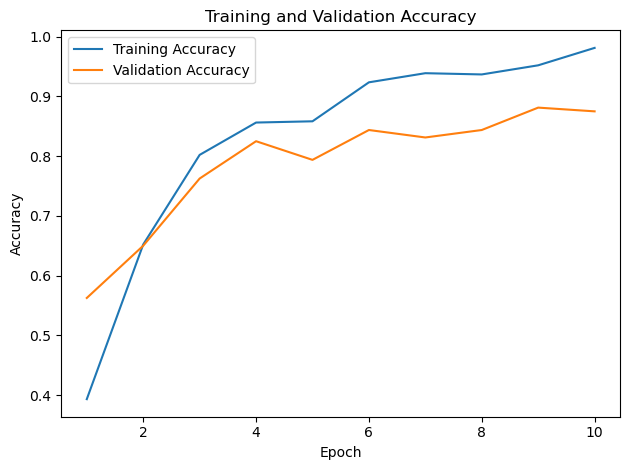

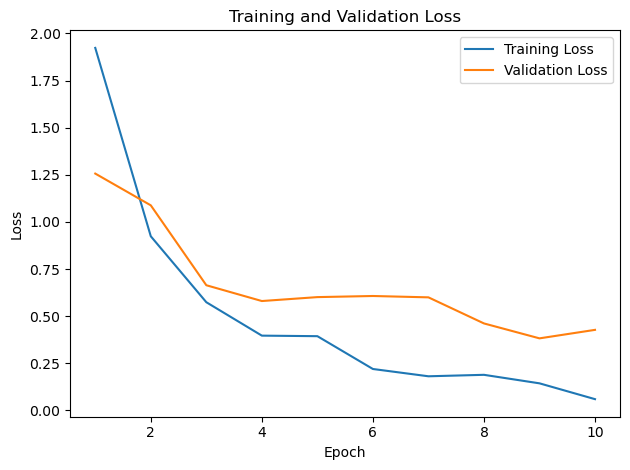

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Data = "C:/Users/USER/Project10/Dataset/train"
Categories = ["ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma", "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya"]

img_size = 100

# Function to create training data
def create_training_data():
    training_data = []
    for CATEGORY in Categories:
        path = os.path.join(Data, CATEGORY)
        class_num = Categories.index(CATEGORY)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Use IMREAD_COLOR for RGB images
                img_array = cv2.resize(img_array, (img_size, img_size))
                inverted_img_array = 255 - img_array  # Invert the colors
                training_data.append([inverted_img_array, class_num])
            except Exception as e:
                pass
    random.shuffle(training_data)
    return training_data

training_data = create_training_data()

x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)

x = np.array(x).reshape(-1, img_size, img_size, 3)  # Use 3 channels for RGB images

# Normalize and one-hot encode the labels
x = x / 255.0
y = to_categorical(y, num_classes=len(Categories))

# Split data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Further split training data into 70% training and 10% validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Load the pre-trained InceptionV3 model without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create your own classifier (top layers)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(len(Categories), activation="softmax"))  # Use softmax activation for multiclass classification

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Classification Report
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print("Accuracy:", np.mean(y_pred_labels == y_true_labels))
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
